In [3]:
import os
import cv2
import shutil
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121, InceptionV3

# **PREPROSESSING DATA**

**Pemanggilan data**

In [5]:
# Path ke file ZIP dan direktori tujuan
zip_path = 'C:/Image1.zip'
Dataset = './Dataset'

# Jika direktori dataset sudah ada, hapus dan buat ulang
if os.path.exists(Dataset):
    shutil.rmtree(Dataset)  # Hapus direktori lama
os.makedirs(Dataset, exist_ok=True)  # Buat ulang direktori

# Ekstrak data dari file ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(Dataset)

In [3]:
classes = [
    'Acne',
    'Actinic Cheilitis',
    'Basall Cell Carcinoma',
    'Bullous Disease',
    'Cacar Air',
    'Eczema',
    'Skin Cancer',
    'Urticaria Hives',
]

**Membagi data test dan train**

In [10]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Direktori asli dataset
dataset_dir = 'Dataset'   # Path dari variabel sebelumnya

# Direktori untuk train dan test
TRAIN_DIR = './Dataset/train'
TEST_DIR = './Dataset/test'

# Daftar kelas atau label dalam dataset
classes = os.listdir(dataset_dir)  # Ini akan mengambil nama folder dalam dataset_dir sebagai label

# Hapus dan buat ulang direktori train dan test jika sudah ada
if os.path.exists(TRAIN_DIR):
    shutil.rmtree(TRAIN_DIR)
if os.path.exists(TEST_DIR):
    shutil.rmtree(TEST_DIR)

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

# Bagi dataset menjadi train dan test
for label in classes:
    label_dir = os.path.join(dataset_dir, label)
    if os.path.exists(label_dir):
        files = os.listdir(label_dir)
        train_files, test_files = train_test_split(
            files, test_size=0.1, random_state=42
        )

        # Buat subdirektori untuk train dan test per label
        os.makedirs(os.path.join(TRAIN_DIR, label), exist_ok=True)
        os.makedirs(os.path.join(TEST_DIR, label), exist_ok=True)

        # Salin file ke direktori train
        for file in train_files:
            src = os.path.join(label_dir, file)
            dst = os.path.join(TRAIN_DIR, label, file)
            shutil.copy(src, dst)

        # Salin file ke direktori test
        for file in test_files:
            src = os.path.join(label_dir, file)
            dst = os.path.join(TEST_DIR, label, file)
            shutil.copy(src, dst)

print("Dataset berhasil dibagi menjadi train dan test.")


Dataset berhasil dibagi menjadi train dan test.


In [1]:
import pandas as pd
TRAIN_DIR = './Dataset/train'
TEST_DIR = './Dataset/test'

# Membuat daftar jumlah data untuk setiap label
data_summary = []

for disease in classes:
    train_path = os.path.join(TRAIN_DIR, disease)
    test_path = os.path.join(TEST_DIR, disease)

    train_count = len(os.listdir(train_path)) if os.path.exists(train_path) else 0
    test_count = len(os.listdir(test_path)) if os.path.exists(test_path) else 0

    data_summary.append({'Disease': disease, 'Train': train_count, 'Test': test_count})

# Membuat tabel menggunakan pandas
df_summary = pd.DataFrame(data_summary)

# Menampilkan tabel
print(df_summary)



NameError: name 'classes' is not defined

**Melakukan masking pada bagian yang tidak diinginkan**

In [14]:
def blur_watermark(image_path, output_path):
    """
    Memburamkan area watermark secara otomatis dengan lebar 2/4 bagian
    dan tinggi 1/5 bagian di tengah gambar.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"File {image_path} tidak dapat dimuat.")

    h, w, _ = image.shape

    # Tentukan area blur
    center_y, center_x = h // 2, w // 2
    box_h = h // 5  # Tinggi blur 1/5 bagian
    box_w = w // 2  # Lebar blur 2/4 bagian (setengah lebar gambar)
    y_min = max(center_y - box_h // 2, 0)
    y_max = min(center_y + box_h // 2, h)
    x_min = max(center_x - box_w // 2, 0)
    x_max = min(center_x + box_w // 2, w)

    # Blur area di tengah
    watermark_region = image[y_min:y_max, x_min:x_max]
    blurred_region = cv2.GaussianBlur(watermark_region, (21, 21), 0)
    image[y_min:y_max, x_min:x_max] = blurred_region

    cv2.imwrite(output_path, image)

def preprocess_dataset(input_dir, output_dir):
    """
    Memburamkan watermark di dataset. Mendukung folder dengan subfolder kategori.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_name in os.listdir(input_dir):
        class_input_dir = os.path.join(input_dir, class_name)
        class_output_dir = os.path.join(output_dir, class_name)

        if not os.path.isdir(class_input_dir):
            print(f"Skipping non-folder: {class_input_dir}")
            continue

        if not os.path.exists(class_output_dir):
            os.makedirs(class_output_dir)

        for image_name in os.listdir(class_input_dir):
            image_path = os.path.join(class_input_dir, image_name)
            output_path = os.path.join(class_output_dir, image_name)

            if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                print(f"Skipping non-image file: {image_path}")
                continue

            try:
                blur_watermark(image_path, output_path)
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

# Hapus hasil sebelumnya
output_dir = './Processed'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
    print(f"Folder {output_dir} berhasil dihapus.")

# Proses ulang dataset
preprocess_dataset('./Dataset/train', './Processed/train')
preprocess_dataset('./Dataset/test', './Processed/test')

print("Proses blur selesai.")

Folder ./Processed berhasil dihapus.
Proses blur selesai.


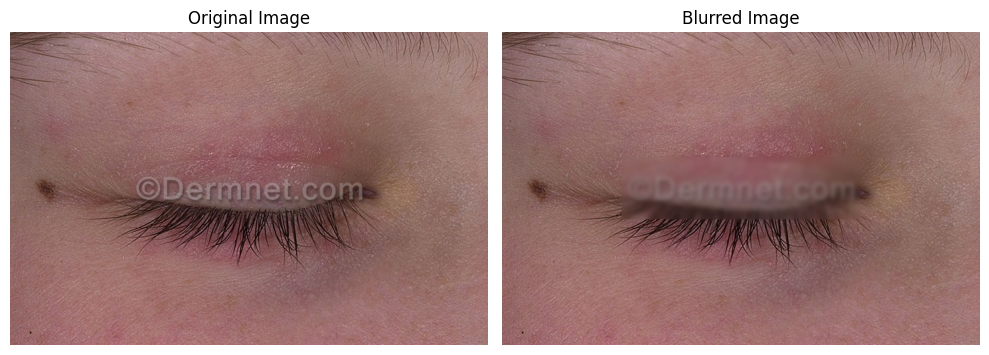

In [16]:
import matplotlib.pyplot as plt

def show_blurred_image(original_path, blurred_path):
    """
    Menampilkan gambar asli dan hasil blur secara berdampingan.
    """
    # Muat gambar asli dan hasil blur
    original_image = cv2.imread(original_path)
    blurred_image = cv2.imread(blurred_path)

    if original_image is None or blurred_image is None:
        raise ValueError("Salah satu gambar tidak dapat dimuat.")

    # Konversi warna dari BGR ke RGB untuk ditampilkan di matplotlib
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    blurred_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB)

    # Plot gambar
    plt.figure(figsize=(10, 5))

    # Gambar asli
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    # Gambar yang diburamkan
    plt.subplot(1, 2, 2)
    plt.imshow(blurred_image)
    plt.title("Blurred Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Contoh penggunaan
original_image_path = './Dataset/train/Acne/07PerioralDermEye.jpg'
blurred_image_path = './Processed/train/Acne/07PerioralDermEye.jpg'

show_blurred_image(original_image_path, blurred_image_path)


**Melakukan balancing data dengan augmentasi gambar**

In [19]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

TRAIN_DIR = './Processed/train'
TEST_DIR = './Processed/test'
#TRAIN_DIR = './Dataset/train'
#TEST_DIR = './Dataset/test'
def balance_data(dataset_dir, target_count=1000):
    """
    Menyeimbangkan jumlah data dalam setiap kelas menggunakan augmentasi gambar,
    dengan augmentasi dilakukan untuk semua gambar di folder secara merata.
    """
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Daftar semua kelas
    classes = os.listdir(dataset_dir)

    for cls in classes:
        class_dir = os.path.join(dataset_dir, cls)
        images = os.listdir(class_dir)

        # Hitung jumlah gambar yang perlu dibuat
        if len(images) < target_count:
            images_to_generate = target_count - len(images)
            print(f"Augmentasi {images_to_generate} gambar untuk kelas: {cls}")

            # Hitung augmentasi per gambar
            augment_per_image = images_to_generate // len(images)
            remainder = images_to_generate % len(images)  # Jika tidak habis dibagi

            generated_count = 0

            # Augmentasi setiap gambar
            for idx, image_file in enumerate(images):
                img_path = os.path.join(class_dir, image_file)
                img = load_img(img_path)  # Corrected: load_img from tensorflow.keras.preprocessing.image
                img_array = img_to_array(img)  # Corrected: img_to_array from tensorflow.keras.preprocessing.image
                img_array = np.expand_dims(img_array, axis=0)

                # Hitung jumlah augmentasi untuk gambar ini
                num_augment = augment_per_image + (1 if idx < remainder else 0)  # Tambahkan sisa augmentasi

                # Augmentasi gambar
                for batch in datagen.flow(
                    img_array,
                    batch_size=1,
                    save_to_dir=class_dir,
                    save_prefix='aug',
                    save_format='jpeg'
                ):
                    generated_count += 1
                    if generated_count >= images_to_generate:
                        break  # Hentikan jika jumlah target tercapai
                    if num_augment <= 0:
                        break
                    num_augment -= 1

# Seimbangkan data pelatihan
balance_data(TRAIN_DIR)


Augmentasi 877 gambar untuk kelas: Acne
Augmentasi 951 gambar untuk kelas: Actinic Cheilitis
Augmentasi 910 gambar untuk kelas: Actinic Keratosis
Augmentasi 839 gambar untuk kelas: Basall Cell Carcinoma
Augmentasi 981 gambar untuk kelas: Bullous Disease
Augmentasi 965 gambar untuk kelas: Cacar Air
Augmentasi 971 gambar untuk kelas: Eczema
Augmentasi 969 gambar untuk kelas: Infeksi jamur
Augmentasi 952 gambar untuk kelas: Kutil
Augmentasi 963 gambar untuk kelas: Skin Cancer
Augmentasi 978 gambar untuk kelas: Urticaria Hives


In [21]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

TRAIN_DIR = './Processed/train'
TEST_DIR = './Processed/test'
#TRAIN_DIR = './Dataset/train'
#TEST_DIR = './Dataset/test'
def balance_data(dataset_dir, target_count=250):
    """
    Menyeimbangkan jumlah data dalam setiap kelas menggunakan augmentasi gambar,
    dengan augmentasi dilakukan untuk semua gambar di folder secara merata.
    """
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Daftar semua kelas
    classes = os.listdir(dataset_dir)

    for cls in classes:
        class_dir = os.path.join(dataset_dir, cls)
        images = os.listdir(class_dir)

        # Hitung jumlah gambar yang perlu dibuat
        if len(images) < target_count:
            images_to_generate = target_count - len(images)
            print(f"Augmentasi {images_to_generate} gambar untuk kelas: {cls}")

            # Hitung augmentasi per gambar
            augment_per_image = images_to_generate // len(images)
            remainder = images_to_generate % len(images)  # Jika tidak habis dibagi

            generated_count = 0

            # Augmentasi setiap gambar
            for idx, image_file in enumerate(images):
                img_path = os.path.join(class_dir, image_file)
                img = load_img(img_path)
                img_array = img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)

                # Hitung jumlah augmentasi untuk gambar ini
                num_augment = augment_per_image + (1 if idx < remainder else 0)

                # Augmentasi gambar
                for batch in datagen.flow(
                    img_array,
                    batch_size=1,
                    save_to_dir=class_dir,
                    save_prefix='aug',
                    save_format='jpeg'
                ):
                    generated_count += 1
                    if generated_count >= images_to_generate:
                        break
                    if num_augment <= 0:
                        break
                    num_augment -= 1

# Seimbangkan data pelatihan
balance_data(TEST_DIR)


Augmentasi 236 gambar untuk kelas: Acne
Augmentasi 244 gambar untuk kelas: Actinic Cheilitis
Augmentasi 240 gambar untuk kelas: Actinic Keratosis
Augmentasi 232 gambar untuk kelas: Basall Cell Carcinoma
Augmentasi 247 gambar untuk kelas: Bullous Disease
Augmentasi 246 gambar untuk kelas: Cacar Air
Augmentasi 246 gambar untuk kelas: Eczema
Augmentasi 246 gambar untuk kelas: Infeksi jamur
Augmentasi 244 gambar untuk kelas: Kutil
Augmentasi 245 gambar untuk kelas: Skin Cancer
Augmentasi 247 gambar untuk kelas: Urticaria Hives


In [15]:
import pandas as pd
TRAIN_DIR = './Processed/train'
TEST_DIR = './Processed/test'

# Membuat daftar jumlah data untuk setiap label
data_summary = []

for disease in classes:
    train_path = os.path.join(TRAIN_DIR, disease)
    test_path = os.path.join(TEST_DIR, disease)

    train_count = len(os.listdir(train_path)) if os.path.exists(train_path) else 0
    test_count = len(os.listdir(test_path)) if os.path.exists(test_path) else 0

    data_summary.append({'Disease': disease, 'Train': train_count, 'Test': test_count})

# Membuat tabel menggunakan pandas
df_summary = pd.DataFrame(data_summary)

# Menampilkan tabel
print(df_summary)



                 Disease  Train  Test
0                   Acne    971   246
1      Actinic Cheilitis    959   247
2  Basall Cell Carcinoma    990   250
3        Bullous Disease    964   246
4              Cacar Air    960   249
5                 Eczema    944   248
6            Skin Cancer    963   248
7        Urticaria Hives    955   249


In [25]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os

def show_augmented_samples(dataset_dir, class_name, sample_to_display=5):
    """
    Menampilkan gambar hasil augmentasi dari folder tertentu.
    """
    class_dir = os.path.join(dataset_dir, class_name)
    augmented_images = [f for f in os.listdir(class_dir) if f.startswith('aug')]

    if not augmented_images:
        print(f"Tidak ada gambar augmentasi ditemukan di kelas: {class_name}")
        return

    print(f"Menampilkan {min(sample_to_display, len(augmented_images))} gambar hasil augmentasi untuk kelas: {class_name}")
    for i, image_file in enumerate(augmented_images[:sample_to_display]):
        img_path = os.path.join(class_dir, image_file)
        img = tf.keras.utils.load_img(img_path)

        plt.figure()
        plt.imshow(img)
        plt.title(f"Augmented Image {i+1} - Class: {class_name}")
        plt.axis('off')
    plt.show()

Menampilkan 3 gambar hasil augmentasi untuk kelas: Acne


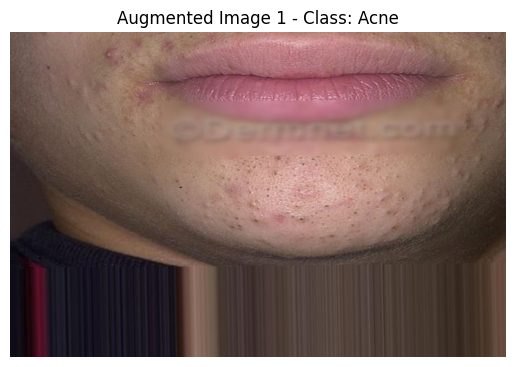

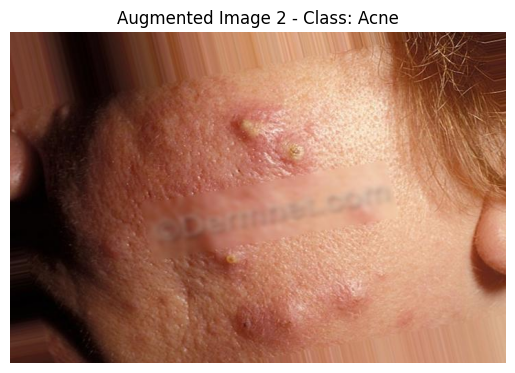

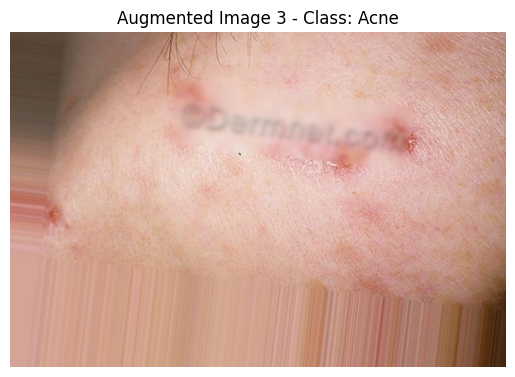

In [27]:
show_augmented_samples(TRAIN_DIR, class_name='Acne', sample_to_display=3)

Menampilkan 3 gambar hasil augmentasi untuk kelas: Kutil


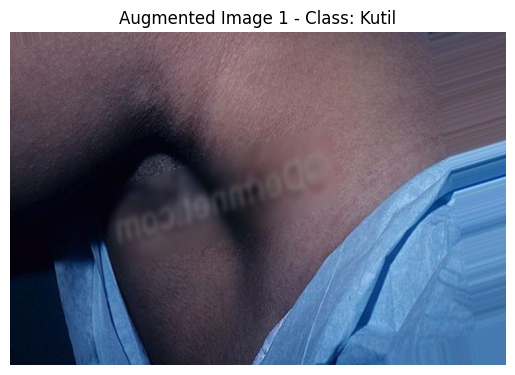

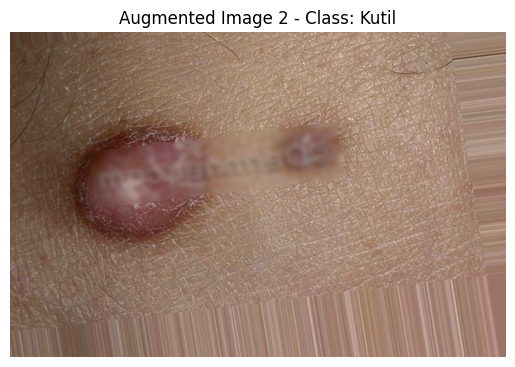

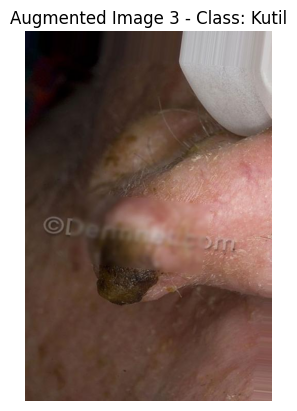

In [29]:
show_augmented_samples(TEST_DIR, class_name='Kutil', sample_to_display=3)

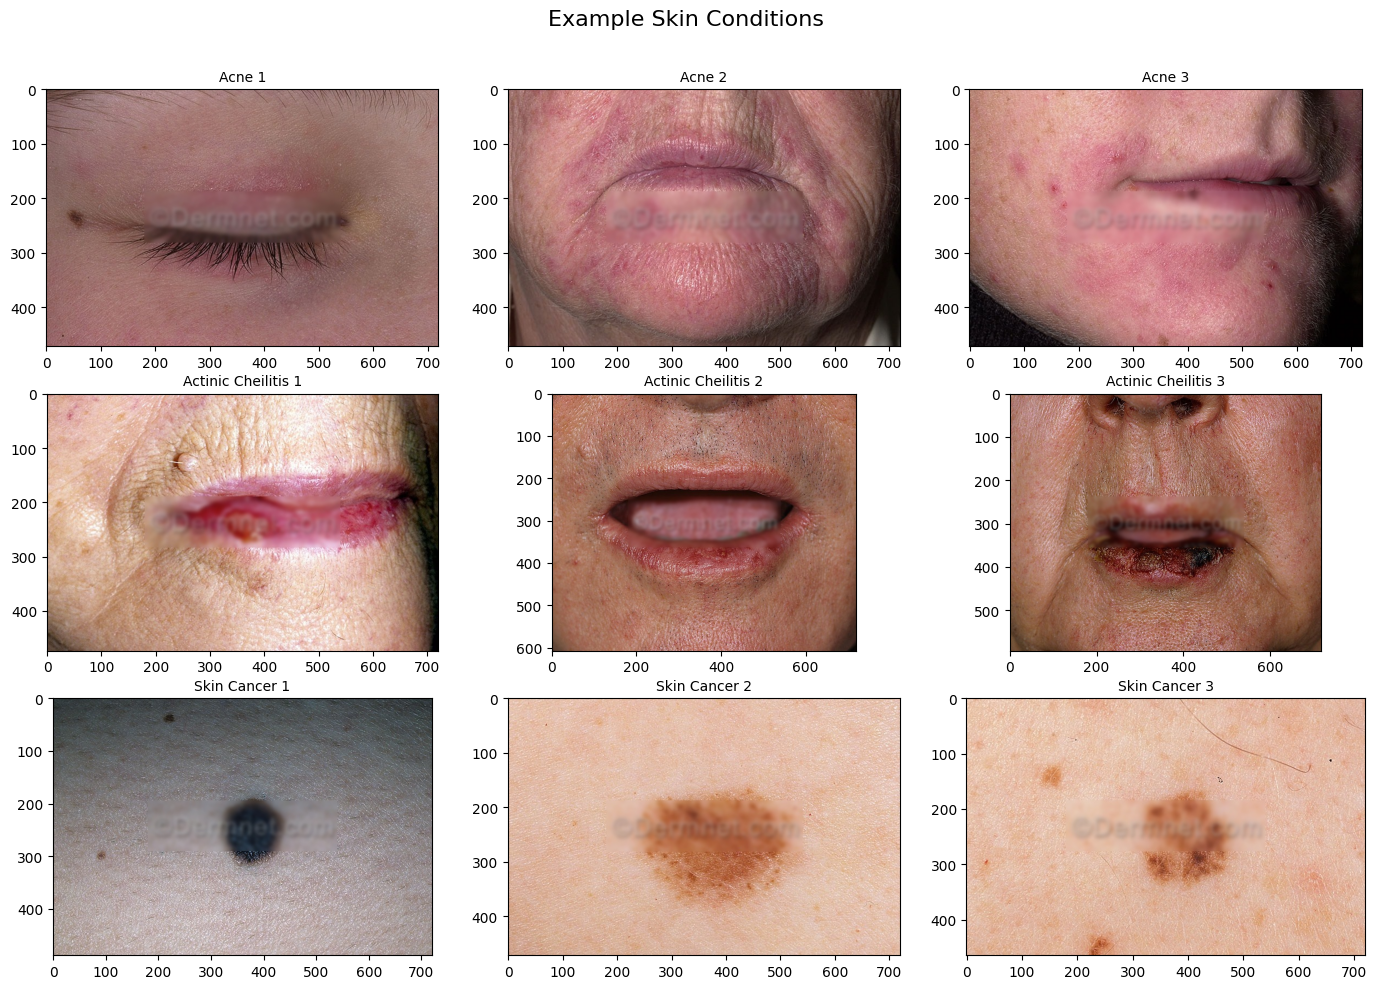

In [31]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# Direktori kategori gambar
categories = [
    "./Processed/train/Acne",
    "./Processed/train/Actinic Cheilitis",
    "./Processed/train/Skin Cancer",
]

# Jumlah gambar per kategori yang ditampilkan
num_images_per_category = 3

# Membuat grid plot
fig, axes = plt.subplots(len(categories), num_images_per_category, figsize=(14, 10))
fig.suptitle('Example Skin Conditions', fontsize=16)

# Menampilkan gambar untuk setiap kategori
for row, category in enumerate(categories):
    files = [os.path.join(category, f) for f in os.listdir(category)[:num_images_per_category]]
    for col, img_path in enumerate(files):
        img = tf.keras.utils.load_img(img_path)
        ax = axes[row, col]
        ax.imshow(img)
        ax.set_title(f"{os.path.basename(category)} {col + 1}", fontsize=10)
        ax.axis('on')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


**Persiapan dan standarisasi data**

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Rescaling

# Path direktori data hasil preprocessing
TRAIN_DIR = './Processed/train'
TEST_DIR = './Processed/test'

# Memuat dataset dari direktori
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIR,
    image_size=(180, 180),
    batch_size=64,
    label_mode="int",  # Label sebagai integer
    shuffle=True  # Pastikan data dilatih secara acak
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TEST_DIR,
    image_size=(180, 180),
    batch_size=64,
    label_mode="int",
    shuffle=False  # Test data tidak perlu diacak
)

# Menstandarisasi dataset (rescale piksel ke [0, 1])
normalization_layer = Rescaling(1.0 / 255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Mengoptimalkan pipeline data (prefetching untuk mempercepat training)
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Informasi dataset
print(f"Number of training batches: {len(train_dataset)}")
print(f"Number of testing batches: {len(test_dataset)}")


Found 7706 files belonging to 8 classes.
Found 1983 files belonging to 8 classes.
Number of training batches: 121
Number of testing batches: 31


# **Pembuatan model**

**1. Custom CNN**

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_custom_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Layer convolutional pertama
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Layer convolutional kedua
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Layer convolutional ketiga
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Flatten layer
        layers.Flatten(),

        # Fully connected layer
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    # Kompilasi model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        #loss='sparse_categorical_crossentropy',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model

# Parameter model
input_shape = (180, 180, 3)
num_classes = 11

# Membuat model
model = create_custom_cnn(input_shape, num_classes)

# Menampilkan summary model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 128)      0

In [37]:
class StopAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.95):
        super(StopAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if train_acc and train_acc >= self.target_accuracy:
            print(f"\nAkurasi pelatihan mencapai {train_acc:.2f}. Pelatihan dihentikan.")
            self.model.stop_training = True

        if val_acc and val_acc >= self.target_accuracy:
            print(f"\nAkurasi validasi mencapai {val_acc:.2f}. Pelatihan dihentikan.")
            self.model.stop_training = True

# Callback EarlyStopping untuk memantau akurasi validasi
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',     # Pantau akurasi validasi
    patience=3,                 # Tunggu hingga 3 epoch tanpa peningkatan
    restore_best_weights=True,  # Kembalikan bobot terbaik setelah berhenti
    verbose=1                   # Tampilkan log saat pelatihan dihentikan
)

# Callback ReduceLROnPlateau untuk menyesuaikan learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  # Pantau akurasi validasi
    factor=0.5,              # Kurangi learning rate 50%
    patience=3,              # Tunggu 3 epoch tanpa peningkatan
    verbose=1,               # Tampilkan informasi perubahan LR
    mode='max'               # Karena kita memaksimalkan akurasi
)

# Melatih model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[
        StopAtAccuracy(target_accuracy=0.95),
        early_stopping,
        reduce_lr
    ]
)

Epoch 1/100
166/166 [==============================] - 53s 233ms/step - loss: 2.0557 - accuracy: 0.2892 - val_loss: 1.7366 - val_accuracy: 0.3997 - lr: 0.0010
Epoch 2/100
166/166 [==============================] - 45s 269ms/step - loss: 1.5247 - accuracy: 0.4668 - val_loss: 1.6091 - val_accuracy: 0.4589 - lr: 0.0010
Epoch 3/100
166/166 [==============================] - 46s 277ms/step - loss: 1.2575 - accuracy: 0.5624 - val_loss: 1.4871 - val_accuracy: 0.5257 - lr: 0.0010
Epoch 4/100
166/166 [==============================] - 46s 277ms/step - loss: 1.0686 - accuracy: 0.6247 - val_loss: 1.5913 - val_accuracy: 0.5771 - lr: 0.0010
Epoch 5/100
166/166 [==============================] - 45s 270ms/step - loss: 0.9347 - accuracy: 0.6736 - val_loss: 1.5605 - val_accuracy: 0.5658 - lr: 0.0010
Epoch 6/100
166/166 [==============================] - 44s 268ms/step - loss: 0.8176 - accuracy: 0.7191 - val_loss: 1.5118 - val_accuracy: 0.5760 - lr: 0.0010
Epoch 7/100
166/166 [=========================

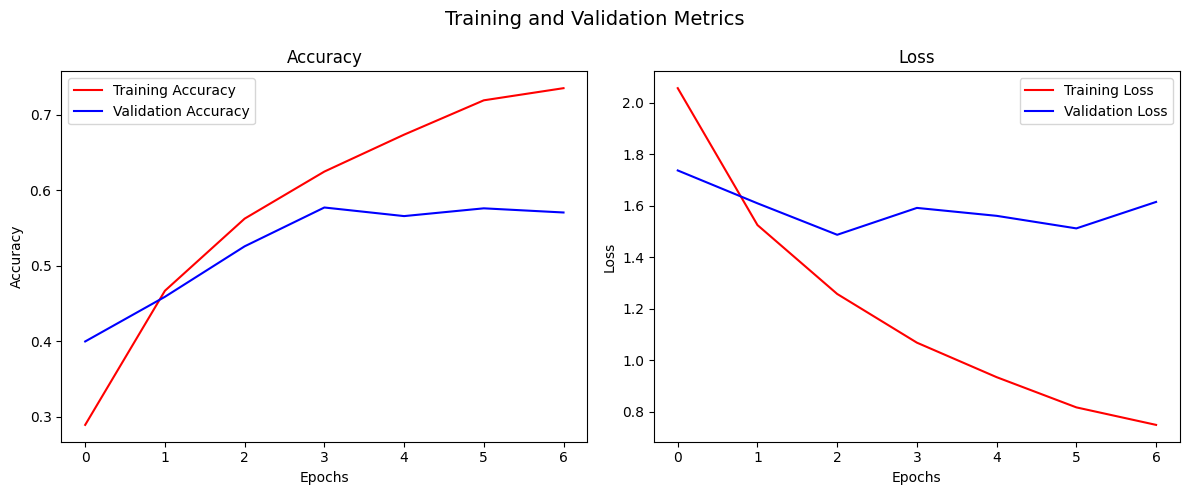

In [39]:
import matplotlib.pyplot as plt  # Pastikan penulisan benar

# Mendapatkan akurasi dan loss dari pelatihan dan validasi
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Mendapatkan jumlah epoch
epochs = range(len(acc))

# Membuat subplots untuk akurasi dan loss
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Lebar disesuaikan untuk visualisasi lebih baik
fig.suptitle('Training and Validation Metrics', fontsize=14)

# Plot akurasi
ax[0].plot(epochs, acc, 'r', label="Training Accuracy")
ax[0].plot(epochs, val_acc, 'b', label="Validation Accuracy")
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot loss
ax[1].plot(epochs, loss, 'r', label="Training Loss")
ax[1].plot(epochs, val_loss, 'b', label="Validation Loss")
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

# Menampilkan plot
plt.tight_layout()
plt.show()


**2. CNN + InceptionV3**

In [49]:
# Memuat model InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# Menambahkan lapisan custom
model = Sequential([
    base_model,  # InceptionV3 sebagai base model
    GlobalAveragePooling2D(),  # Global average pooling untuk mengurangi dimensi
    Dense(1024, activation='relu'),  # Lapisan fully connected
    Dense(11, activation='softmax')  # Output layer
])
# Menampilkan summary model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_7 (Dense)             (None, 11)                11275     
                                                                 
Total params: 23,912,235
Trainable params: 23,877,803
Non-trainable params: 34,432
_________________________________________________________________


In [41]:
# Membekukan lapisan-lapisan dari base model
base_model.trainable = False

# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Training awal (head training)
history_initial = model.fit(
    train_dataset,  # Data training
    epochs=10,
    validation_data=test_dataset  # Data validation
)

Epoch 1/10
166/166 [==============================] - 48s 262ms/step - loss: 0.9625 - accuracy: 0.7356 - val_loss: 0.9927 - val_accuracy: 0.6877
Epoch 2/10
166/166 [==============================] - 42s 254ms/step - loss: 0.3077 - accuracy: 0.8983 - val_loss: 0.9514 - val_accuracy: 0.7101
Epoch 3/10
166/166 [==============================] - 41s 250ms/step - loss: 0.2033 - accuracy: 0.9362 - val_loss: 0.9624 - val_accuracy: 0.7377
Epoch 4/10
166/166 [==============================] - 41s 248ms/step - loss: 0.1368 - accuracy: 0.9559 - val_loss: 1.0230 - val_accuracy: 0.7348
Epoch 5/10
166/166 [==============================] - 42s 251ms/step - loss: 0.0988 - accuracy: 0.9692 - val_loss: 0.9128 - val_accuracy: 0.7443
Epoch 6/10
166/166 [==============================] - 42s 253ms/step - loss: 0.0689 - accuracy: 0.9805 - val_loss: 0.9334 - val_accuracy: 0.7733
Epoch 7/10
166/166 [==============================] - 42s 251ms/step - loss: 0.0609 - accuracy: 0.9819 - val_loss: 0.7860 - val_ac

In [43]:
# Membuka beberapa lapisan terakhir untuk fine-tuning
base_model.trainable = True
fine_tune_at = 100  # Mulai fine-tuning dari lapisan ke-100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Kompilasi ulang model untuk fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Learning rate lebih kecil untuk fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning
history_fine_tune = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset
)

Epoch 1/10
166/166 [==============================] - 71s 387ms/step - loss: 0.2427 - accuracy: 0.9222 - val_loss: 0.8490 - val_accuracy: 0.8035
Epoch 2/10
166/166 [==============================] - 64s 388ms/step - loss: 0.0087 - accuracy: 0.9969 - val_loss: 0.5855 - val_accuracy: 0.8417
Epoch 3/10
166/166 [==============================] - 62s 376ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.6010 - val_accuracy: 0.8343
Epoch 4/10
166/166 [==============================] - 64s 383ms/step - loss: 6.1820e-04 - accuracy: 0.9999 - val_loss: 0.6137 - val_accuracy: 0.8310
Epoch 5/10
166/166 [==============================] - 63s 378ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 0.6217 - val_accuracy: 0.8347
Epoch 6/10
166/166 [==============================] - 65s 390ms/step - loss: 2.1884e-04 - accuracy: 0.9999 - val_loss: 0.6172 - val_accuracy: 0.8373
Epoch 7/10
166/166 [==============================] - 63s 380ms/step - loss: 2.0746e-04 - accuracy: 0.9999 - val_loss: 0.6

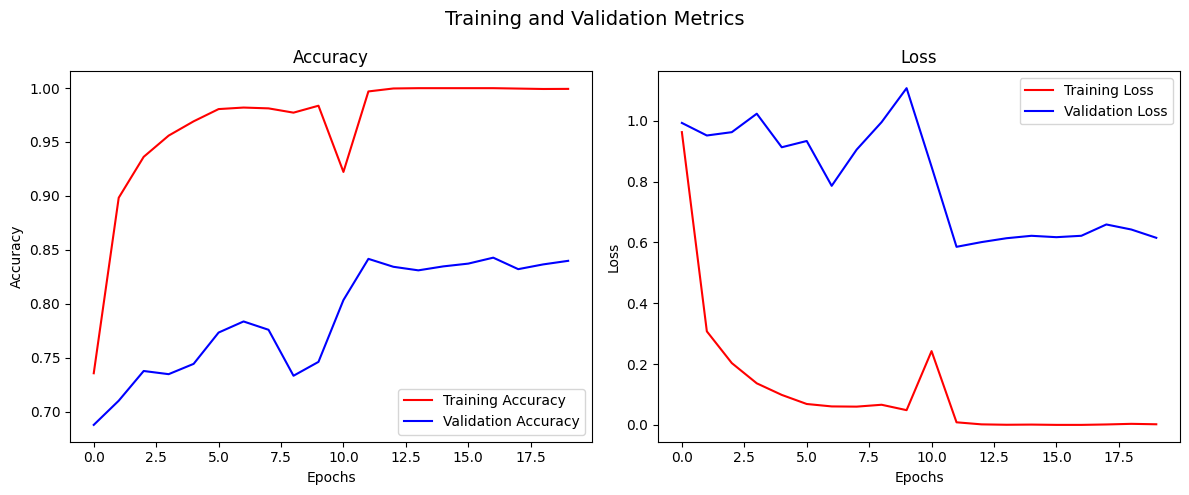

In [45]:
# Plotting hasil training dan fine-tuning
def plot_training(history, fine_tune_history=None):
    # Gabungkan hasil dari history awal dan fine-tuning
    if fine_tune_history:
        acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
        val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
        loss = history.history['loss'] + fine_tune_history.history['loss']
        val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

    # Mendapatkan jumlah epoch
    epochs = range(len(acc))

    # Membuat subplots untuk akurasi dan loss
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Training and Validation Metrics', fontsize=14)

    # Plot akurasi
    ax[0].plot(epochs, acc, 'r', label="Training Accuracy")
    ax[0].plot(epochs, val_acc, 'b', label="Validation Accuracy")
    ax[0].set_title('Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Plot loss
    ax[1].plot(epochs, loss, 'r', label="Training Loss")
    ax[1].plot(epochs, val_loss, 'b', label="Validation Loss")
    ax[1].set_title('Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    # Menampilkan plot
    plt.tight_layout()
    plt.show()

# Plot hasil pelatihan
plot_training(history_initial, fine_tune_history=history_fine_tune)

**3. CNN + DenseNet121**

In [23]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Model

In [7]:
def fix_layer_names(model):
    for layer in model.layers:
        if '/' in layer.name:
            layer._name = layer.name.replace('/', '_')  # Ganti '/' dengan '_'
    return model

def build_densenet_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
    base_model = fix_layer_names(base_model)  # Memperbaiki nama lapisan
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)  # Fully connected layer
    predictions = Dense(8, activation='softmax')(x)  # Output layer

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False  # Freeze layers

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

# Membuat model DenseNet
densenet_model = build_densenet_model()
densenet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 186, 186, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']         

In [9]:
# Callback untuk menghentikan pelatihan setelah akurasi mencapai target
class StopAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.97):
        super(StopAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if train_acc and train_acc >= self.target_accuracy:
            print(f"\nAkurasi pelatihan mencapai {train_acc:.2f}. Pelatihan dihentikan.")
            self.model.stop_training = True

        if val_acc and val_acc >= self.target_accuracy:
            print(f"\nAkurasi validasi mencapai {val_acc:.2f}. Pelatihan dihentikan.")
            self.model.stop_training = True

# Callback EarlyStopping untuk memantau akurasi validasi
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',     # Pantau akurasi validasi
    patience=3,                 # Tunggu hingga 3 epoch tanpa peningkatan
    restore_best_weights=True,  # Kembalikan bobot terbaik setelah berhenti
    verbose=1                   # Tampilkan log saat pelatihan dihentikan
)

# Callback ReduceLROnPlateau untuk menyesuaikan learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  # Pantau akurasi validasi
    factor=0.5,              # Kurangi learning rate 50%
    patience=3,              # Tunggu 3 epoch tanpa peningkatan
    verbose=1,               # Tampilkan informasi perubahan LR
    mode='max'               # Karena kita memaksimalkan akurasi
)
            
# Callback ModelCheckpoint untuk menyimpan bobot terbaik
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',   # Nama file untuk menyimpan bobot
    monitor='val_accuracy',            # Pantau akurasi validasi
    save_best_only=True,               # Hanya simpan bobot terbaik
    save_weights_only=True,            # Simpan hanya bobot, bukan seluruh model
    mode='max',                        # Karena kita memaksimalkan akurasi
    verbose=1                          # Tampilkan log saat bobot disimpan
)

# Latih model DenseNet
history_densenet = densenet_model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    callbacks=[
        StopAtAccuracy(target_accuracy=0.97),  # Callback custom
        early_stopping,                        # Hentikan jika stagnan
        reduce_lr,                             # Sesuaikan learning rate
        model_checkpoint                       # Simpan bobot terbaik
    ]
)

# Muat kembali bobot terbaik setelah pelatihan selesai
densenet_model.load_weights('best_model.h5')

Epoch 1/50
121/121 [==============================] - ETA: 0s - loss: 1.4435 - accuracy: 0.5193
Epoch 1: val_accuracy improved from -inf to 0.72567, saving model to best_model.h5
121/121 [==============================] - 119s 636ms/step - loss: 1.4435 - accuracy: 0.5193 - val_loss: 0.8468 - val_accuracy: 0.7257 - lr: 1.0000e-04
Epoch 2/50
121/121 [==============================] - ETA: 0s - loss: 0.6558 - accuracy: 0.8217
Epoch 2: val_accuracy improved from 0.72567 to 0.82703, saving model to best_model.h5
121/121 [==============================] - 92s 756ms/step - loss: 0.6558 - accuracy: 0.8217 - val_loss: 0.5472 - val_accuracy: 0.8270 - lr: 1.0000e-04
Epoch 3/50
121/121 [==============================] - ETA: 0s - loss: 0.4434 - accuracy: 0.8811
Epoch 3: val_accuracy improved from 0.82703 to 0.87040, saving model to best_model.h5
121/121 [==============================] - 89s 738ms/step - loss: 0.4434 - accuracy: 0.8811 - val_loss: 0.4219 - val_accuracy: 0.8704 - lr: 1.0000e-04
Epo

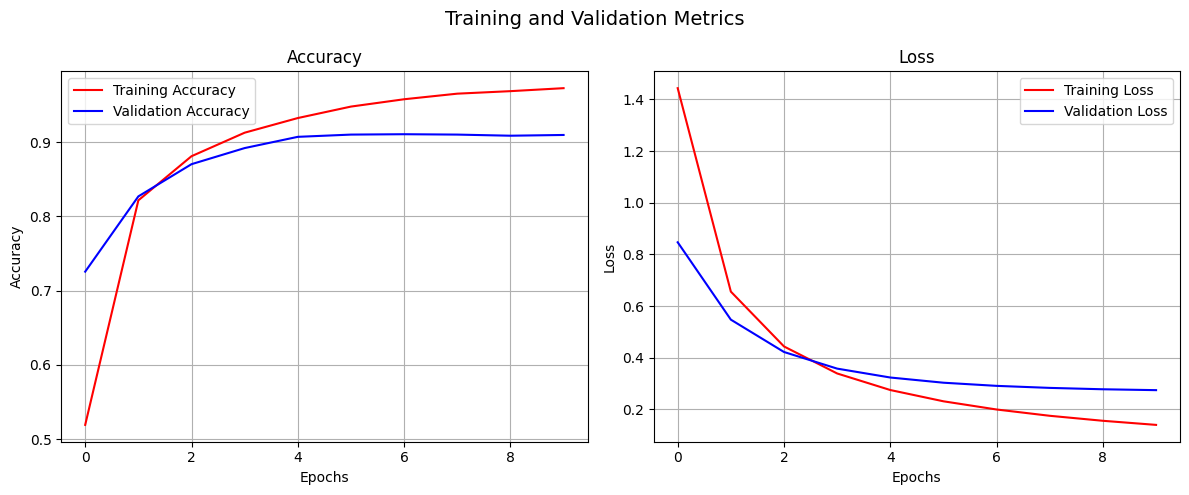

In [11]:
# Mendapatkan akurasi dan loss dari pelatihan dan validasi
acc = history_densenet.history['accuracy']
val_acc = history_densenet.history['val_accuracy']
loss = history_densenet.history['loss']
val_loss = history_densenet.history['val_loss']

# Mendapatkan jumlah epoch
epochs = range(len(acc))

# Membuat subplots untuk akurasi dan loss
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Training and Validation Metrics', fontsize=14)

# Plot akurasi
ax[0].plot(epochs, acc, 'r', label="Training Accuracy")
ax[0].plot(epochs, val_acc, 'b', label="Validation Accuracy")
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid()

# Plot loss
ax[1].plot(epochs, loss, 'r', label="Training Loss")
ax[1].plot(epochs, val_loss, 'b', label="Validation Loss")
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid()

# Menampilkan plot
plt.tight_layout()
plt.show()



31/31 [==============================] - 18s 350ms/step


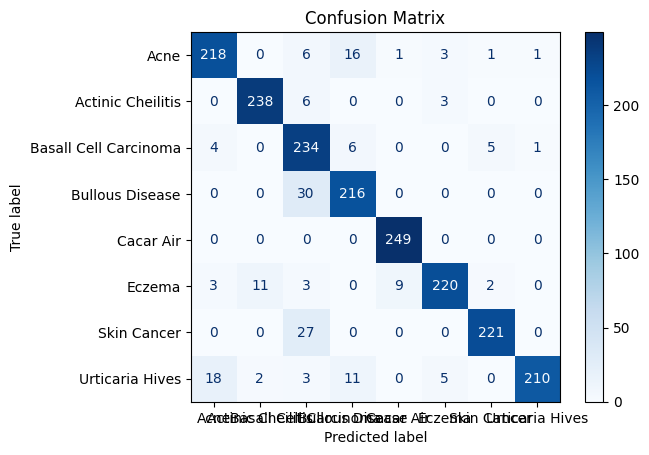

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prediksi pada dataset validasi
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  
y_pred = np.argmax(densenet_model.predict(test_dataset), axis=-1)  

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)  
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [57]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

#TRAIN_DIR = './Processed/train'
#TEST_DIR = './Processed/test'
TRAIN_DIR = './Dataset/train'
TEST_DIR = './Dataset/test'
def balance_data(dataset_dir, target_count=1000):
    """
    Menyeimbangkan jumlah data dalam setiap kelas menggunakan augmentasi gambar,
    dengan augmentasi dilakukan untuk semua gambar di folder secara merata.
    """
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Daftar semua kelas
    classes = os.listdir(dataset_dir)

    for cls in classes:
        class_dir = os.path.join(dataset_dir, cls)
        images = os.listdir(class_dir)

        # Hitung jumlah gambar yang perlu dibuat
        if len(images) < target_count:
            images_to_generate = target_count - len(images)
            print(f"Augmentasi {images_to_generate} gambar untuk kelas: {cls}")

            # Hitung augmentasi per gambar
            augment_per_image = images_to_generate // len(images)
            remainder = images_to_generate % len(images)  # Jika tidak habis dibagi

            generated_count = 0

            # Augmentasi setiap gambar
            for idx, image_file in enumerate(images):
                img_path = os.path.join(class_dir, image_file)
                img = load_img(img_path)  # Corrected: load_img from tensorflow.keras.preprocessing.image
                img_array = img_to_array(img)  # Corrected: img_to_array from tensorflow.keras.preprocessing.image
                img_array = np.expand_dims(img_array, axis=0)

                # Hitung jumlah augmentasi untuk gambar ini
                num_augment = augment_per_image + (1 if idx < remainder else 0)  # Tambahkan sisa augmentasi

                # Augmentasi gambar
                for batch in datagen.flow(
                    img_array,
                    batch_size=1,
                    save_to_dir=class_dir,
                    save_prefix='aug',
                    save_format='jpeg'
                ):
                    generated_count += 1
                    if generated_count >= images_to_generate:
                        break  # Hentikan jika jumlah target tercapai
                    if num_augment <= 0:
                        break
                    num_augment -= 1

# Seimbangkan data pelatihan
balance_data(TRAIN_DIR)


Augmentasi 877 gambar untuk kelas: Acne
Augmentasi 951 gambar untuk kelas: Actinic Cheilitis
Augmentasi 910 gambar untuk kelas: Actinic Keratosis
Augmentasi 839 gambar untuk kelas: Basall Cell Carcinoma
Augmentasi 981 gambar untuk kelas: Bullous Disease
Augmentasi 965 gambar untuk kelas: Cacar Air
Augmentasi 971 gambar untuk kelas: Eczema
Augmentasi 969 gambar untuk kelas: Infeksi jamur
Augmentasi 952 gambar untuk kelas: Kutil
Augmentasi 963 gambar untuk kelas: Skin Cancer
Augmentasi 978 gambar untuk kelas: Urticaria Hives


In [59]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

#TRAIN_DIR = './Processed/train'
#TEST_DIR = './Processed/test'
TRAIN_DIR = './Dataset/train'
TEST_DIR = './Dataset/test'
def balance_data(dataset_dir, target_count=250):
    """
    Menyeimbangkan jumlah data dalam setiap kelas menggunakan augmentasi gambar,
    dengan augmentasi dilakukan untuk semua gambar di folder secara merata.
    """
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Daftar semua kelas
    classes = os.listdir(dataset_dir)

    for cls in classes:
        class_dir = os.path.join(dataset_dir, cls)
        images = os.listdir(class_dir)

        # Hitung jumlah gambar yang perlu dibuat
        if len(images) < target_count:
            images_to_generate = target_count - len(images)
            print(f"Augmentasi {images_to_generate} gambar untuk kelas: {cls}")

            # Hitung augmentasi per gambar
            augment_per_image = images_to_generate // len(images)
            remainder = images_to_generate % len(images)  # Jika tidak habis dibagi

            generated_count = 0

            # Augmentasi setiap gambar
            for idx, image_file in enumerate(images):
                img_path = os.path.join(class_dir, image_file)
                img = load_img(img_path)
                img_array = img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)

                # Hitung jumlah augmentasi untuk gambar ini
                num_augment = augment_per_image + (1 if idx < remainder else 0)

                # Augmentasi gambar
                for batch in datagen.flow(
                    img_array,
                    batch_size=1,
                    save_to_dir=class_dir,
                    save_prefix='aug',
                    save_format='jpeg'
                ):
                    generated_count += 1
                    if generated_count >= images_to_generate:
                        break
                    if num_augment <= 0:
                        break
                    num_augment -= 1

# Seimbangkan data pelatihan
balance_data(TEST_DIR)

Augmentasi 236 gambar untuk kelas: Acne
Augmentasi 244 gambar untuk kelas: Actinic Cheilitis
Augmentasi 240 gambar untuk kelas: Actinic Keratosis
Augmentasi 232 gambar untuk kelas: Basall Cell Carcinoma
Augmentasi 247 gambar untuk kelas: Bullous Disease
Augmentasi 246 gambar untuk kelas: Cacar Air
Augmentasi 246 gambar untuk kelas: Eczema
Augmentasi 246 gambar untuk kelas: Infeksi jamur
Augmentasi 244 gambar untuk kelas: Kutil
Augmentasi 245 gambar untuk kelas: Skin Cancer
Augmentasi 247 gambar untuk kelas: Urticaria Hives


In [15]:
import pandas as pd
# Membuat daftar jumlah data untuk setiap label
data_summary = []

for disease in classes:
    train_path = os.path.join(TRAIN_DIR, disease)
    test_path = os.path.join(TEST_DIR, disease)

    train_count = len(os.listdir(train_path)) if os.path.exists(train_path) else 0
    test_count = len(os.listdir(test_path)) if os.path.exists(test_path) else 0

    data_summary.append({'Disease': disease, 'Train': train_count, 'Test': test_count})

# Membuat tabel menggunakan pandas
df_summary = pd.DataFrame(data_summary)

# Menampilkan tabel
print(df_summary)

                 Disease  Train  Test
0                   Acne    971   246
1      Actinic Cheilitis    959   247
2  Basall Cell Carcinoma    990   250
3        Bullous Disease    964   246
4              Cacar Air    960   249
5                 Eczema    944   248
6            Skin Cancer    963   248
7        Urticaria Hives    955   249


In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Rescaling

# Path direktori data hasil preprocessing
#TRAIN_DIR = './Processed/train'
#TEST_DIR = './Processed/test'
TRAIN_DIR = './Dataset/train'
TEST_DIR = './Dataset/test'

# Memuat dataset dari direktori
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIR,
    image_size=(180, 180),
    batch_size=64,
    label_mode="int",  # Label sebagai integer
    shuffle=True  # Pastikan data dilatih secara acak
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TEST_DIR,
    image_size=(180, 180),
    batch_size=64,
    label_mode="int",
    shuffle=False  # Test data tidak perlu diacak
)

# Menstandarisasi dataset (rescale piksel ke [0, 1])
normalization_layer = Rescaling(1.0 / 255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Mengoptimalkan pipeline data (prefetching untuk mempercepat training)
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Informasi dataset
print(f"Number of training batches: {len(train_dataset)}")
print(f"Number of testing batches: {len(test_dataset)}")

Found 7709 files belonging to 8 classes.
Found 1973 files belonging to 8 classes.
Number of training batches: 121
Number of testing batches: 31


In [43]:
def fix_layer_names(model):
    for layer in model.layers:
        if '/' in layer.name:
            layer._name = layer.name.replace('/', '_')  # Ganti '/' dengan '_'
    return model

def build_densenet_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
    base_model = fix_layer_names(base_model)  # Memperbaiki nama lapisan
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)  # Fully connected layer
    predictions = Dense(8, activation='softmax')(x)  # Output layer

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False  # Freeze layers

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

# Membuat model DenseNet
densenet_model = build_densenet_model()
densenet_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_8 (ZeroPadding2  (None, 186, 186, 3)  0          ['input_6[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9408        ['zero_padding2d_8[0][0]']       
                                                                                            

In [44]:
# Callback untuk menghentikan pelatihan setelah akurasi mencapai target
class StopAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.97):
        super(StopAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if train_acc and train_acc >= self.target_accuracy:
            print(f"\nAkurasi pelatihan mencapai {train_acc:.2f}. Pelatihan dihentikan.")
            self.model.stop_training = True

        if val_acc and val_acc >= self.target_accuracy:
            print(f"\nAkurasi validasi mencapai {val_acc:.2f}. Pelatihan dihentikan.")
            self.model.stop_training = True

# Callback EarlyStopping untuk memantau akurasi validasi
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',     # Pantau akurasi validasi
    patience=3,                 # Tunggu hingga 3 epoch tanpa peningkatan
    restore_best_weights=True,  # Kembalikan bobot terbaik setelah berhenti
    verbose=1                   # Tampilkan log saat pelatihan dihentikan
)

# Callback ReduceLROnPlateau untuk menyesuaikan learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  # Pantau akurasi validasi
    factor=0.5,              # Kurangi learning rate 50%
    patience=3,              # Tunggu 3 epoch tanpa peningkatan
    verbose=1,               # Tampilkan informasi perubahan LR
    mode='max'               # Karena kita memaksimalkan akurasi
)
            
# Callback ModelCheckpoint untuk menyimpan bobot terbaik
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model1.h5',   # Nama file untuk menyimpan bobot
    monitor='val_accuracy',            # Pantau akurasi validasi
    save_best_only=True,               # Hanya simpan bobot terbaik
    save_weights_only=True,            # Simpan hanya bobot, bukan seluruh model
    mode='max',                        # Karena kita memaksimalkan akurasi
    verbose=1                          # Tampilkan log saat bobot disimpan
)

# Latih model DenseNet
history_densenet = densenet_model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    callbacks=[
        StopAtAccuracy(target_accuracy=0.97),  # Callback custom
        early_stopping,                        # Hentikan jika stagnan
        reduce_lr,                             # Sesuaikan learning rate
        model_checkpoint                       # Simpan bobot terbaik
    ]
)

# Muat kembali bobot terbaik setelah pelatihan selesai
densenet_model.load_weights('best_model1.h5')

Epoch 1/50
121/121 [==============================] - ETA: 0s - loss: 1.4636 - accuracy: 0.5053
Epoch 1: val_accuracy improved from -inf to 0.72073, saving model to best_model1.h5
121/121 [==============================] - 56s 431ms/step - loss: 1.4636 - accuracy: 0.5053 - val_loss: 0.9043 - val_accuracy: 0.7207 - lr: 1.0000e-04
Epoch 2/50
121/121 [==============================] - ETA: 0s - loss: 0.7152 - accuracy: 0.7939
Epoch 2: val_accuracy improved from 0.72073 to 0.81956, saving model to best_model1.h5
121/121 [==============================] - 47s 391ms/step - loss: 0.7152 - accuracy: 0.7939 - val_loss: 0.5659 - val_accuracy: 0.8196 - lr: 1.0000e-04
Epoch 3/50
121/121 [==============================] - ETA: 0s - loss: 0.4902 - accuracy: 0.8613
Epoch 3: val_accuracy improved from 0.81956 to 0.86923, saving model to best_model1.h5
121/121 [==============================] - 46s 383ms/step - loss: 0.4902 - accuracy: 0.8613 - val_loss: 0.4245 - val_accuracy: 0.8692 - lr: 1.0000e-04
E

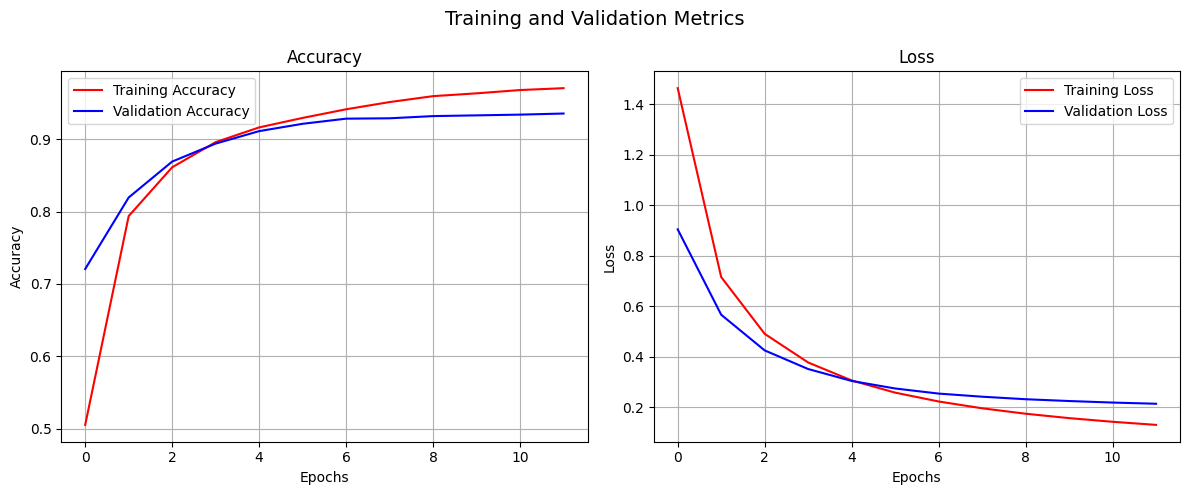

In [47]:
# Mendapatkan akurasi dan loss dari pelatihan dan validasi
acc = history_densenet.history['accuracy']
val_acc = history_densenet.history['val_accuracy']
loss = history_densenet.history['loss']
val_loss = history_densenet.history['val_loss']

# Mendapatkan jumlah epoch
epochs = range(len(acc))

# Membuat subplots untuk akurasi dan loss
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Training and Validation Metrics', fontsize=14)

# Plot akurasi
ax[0].plot(epochs, acc, 'r', label="Training Accuracy")
ax[0].plot(epochs, val_acc, 'b', label="Validation Accuracy")
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid()

# Plot loss
ax[1].plot(epochs, loss, 'r', label="Training Loss")
ax[1].plot(epochs, val_loss, 'b', label="Validation Loss")
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid()

# Menampilkan plot
plt.tight_layout()
plt.show()

31/31 [==============================] - 10s 262ms/step


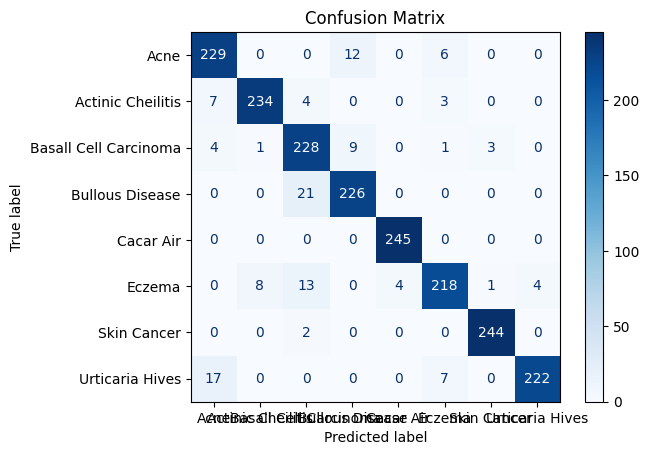

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prediksi pada dataset validasi
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  
y_pred = np.argmax(densenet_model.predict(test_dataset), axis=-1)  

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)  
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [51]:
import json

# Metadata model
metadata = {
    "model_name": "DenseNet",
    "version": "1.0",
    "training_data": "Skin Disease Dataset",
    "validation_accuracy": 0.94,  
    "training_accuracy": 0.97,    
    "epochs": 12,
    "optimizer": "Adam",
    "learning_rate": 0.0001,
    "loss_function": "SparseCategoricalCrossentropy",
    "date_trained": "2024-12-05",  # Update tanggal
    "notes": "Model trained for skin disease classification. Validation accuracy achieved 94%."
}

# Nama file untuk metadata
metadata_file = "model_metadata_bestmodel1.json"

# Simpan metadata ke dalam file JSON
with open(metadata_file, "w") as file:
    json.dump(metadata, file, indent=4)

print(f"Metadata berhasil disimpan di {metadata_file}")

Metadata berhasil disimpan di model_metadata_bestmodel1.json


In [57]:
# 1. Menyimpan model dalam format H5
densenet_model.save('model_dermatoai94.h5')

In [93]:
from tensorflow.keras.models import load_model

# Jika menggunakan layer fungsional, beri tahu `load_model` untuk mengenali layer tersebut
model = load_model('model_dermatoai94.h5')
print("Model berhasil dimuat.")

Model berhasil dimuat.


In [105]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Fungsi untuk memuat dan memproses gambar
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(180, 180))  # Sesuaikan ukuran dengan input model
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch dimension
    img_array = img_array / 255.0  # Normalisasi
    return img_array

# Masukkan path gambar baru
image_path = 'C:/Dataset/images8.jpeg'
input_image = preprocess_image(image_path)

# Prediksi
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions)
confidence = np.max(predictions)
 
labels = ["Acne",
    "Actinic Cheilitis",
    "Basall Cell Carcinoma",
    "Bullous Disease",
    "Cacar Air",
    "Eczema",
    "Skin Cancer",
    "Urticaria Hives"]  
print(f"Prediksi: {labels[predicted_class]} dengan kepercayaan {confidence:.2f}")

1/1 [==============================] - 0s 36ms/step
Prediksi: Bullous Disease dengan kepercayaan 0.46


In [107]:
import tensorflow as tf
import zipfile
import os

# Simpan model dalam format H5
densenet_model.save('model_dermatoai94%.h5')  # Format H5

# Simpan model dalam format SavedModel
densenet_model.save('model_dermatoai94%_savedmodel')  # Format SavedModel

# Simpan model dalam format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(densenet_model)
tflite_model = converter.convert()

# Simpan file TFLite ke disk
with open('model_dermatoai94%.tflite', 'wb') as f:
    f.write(tflite_model)

# Membuat file ZIP untuk mengarsipkan semua model yang disimpan
with zipfile.ZipFile('model_dermatoai94%.zip', 'w') as zipf:
    # Menambahkan file H5
    zipf.write('model_dermatoai94%.h5', arcname='model_dermatoai94%.h5')
    
    # Menambahkan folder SavedModel
    for root, dirs, files in os.walk('model_dermatoai94%_savedmodel'):
        for file in files:
            zipf.write(os.path.join(root, file), 
                       arcname=os.path.relpath(os.path.join(root, file), 'model_dermatoai94%_savedmodel'))
    
    # Menambahkan file TFLite
    zipf.write('model_dermatoai94%.tflite', arcname='model_dermatoai94%.tflite')

# Semua model telah disimpan dan dimasukkan ke dalam file ZIP bernama 'model_baru.zip'
print("Model telah disimpan dalam berbagai format dan dikompresi dalam model_dermatoai94%.zip")

INFO:tensorflow:Assets written to: model_dermatoai94%_savedmodel\assets


INFO:tensorflow:Assets written to: model_dermatoai94%_savedmodel\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpp3j3toq8\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpp3j3toq8\assets


Model telah disimpan dalam berbagai format dan dikompresi dalam model_dermatoai94%.zip


In [37]:
from tensorflow.keras.models import load_model

# Jika menggunakan layer fungsional, beri tahu `load_model` untuk mengenali layer tersebut
model = load_model('model_densenet1.h5')
print("Model berhasil dimuat.")

Model berhasil dimuat.


In [65]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Fungsi untuk memuat dan memproses gambar
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(180, 180))  # Sesuaikan ukuran dengan input model
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch dimension
    img_array = img_array / 255.0  # Normalisasi
    return img_array

# Masukkan path gambar baru
image_path = 'C:/Dataset/images1.jpeg'
input_image = preprocess_image(image_path)

# Prediksi
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions)
confidence = np.max(predictions)
 
labels = ["Acne",
    "Actinic Cheilitis",
    "Actinic Keratosis",
    "Basall Cell Carcinoma",
    "Bullous Disease",
    "Cacar Air",
    "Eczema",
    "Infeksi Jamur",
    "Kutil",
    "Skin Cancer",
    "Urticaria Hives",]  
print(f"Prediksi: {labels[predicted_class]} dengan kepercayaan {confidence:.2f}")

1/1 [==============================] - 0s 114ms/step
Prediksi: Infeksi Jamur dengan kepercayaan 0.57


In [13]:
# Memuat model InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# Menambahkan lapisan custom
model = Sequential([
    base_model,  # InceptionV3 sebagai base model
    GlobalAveragePooling2D(),  # Global average pooling untuk mengurangi dimensi
    Dense(1024, activation='relu'),  # Lapisan fully connected
    Dense(11, activation='softmax')  # Output layer
])
# Menampilkan summary model
model.summary()
# Membuka beberapa lapisan terakhir untuk fine-tuning
base_model.trainable = True
fine_tune_at = 75  # Mulai fine-tuning dari lapisan ke-100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Kompilasi ulang model untuk fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.00001),  # Learning rate lebih kecil untuk fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_3 (Dense)             (None, 11)                11275     
                                                                 
Total params: 23,912,235
Trainable params: 23,877,803
Non-trainable params: 34,432
_________________________________________________________________


In [14]:
# Callback untuk menghentikan pelatihan setelah akurasi mencapai target
class StopAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.97):
        super(StopAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if train_acc and train_acc >= self.target_accuracy:
            print(f"\nAkurasi pelatihan mencapai {train_acc:.2f}. Pelatihan dihentikan.")
            self.model.stop_training = True

        if val_acc and val_acc >= self.target_accuracy:
            print(f"\nAkurasi validasi mencapai {val_acc:.2f}. Pelatihan dihentikan.")
            self.model.stop_training = True

# Callback EarlyStopping untuk memantau akurasi validasi
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',     # Pantau akurasi validasi
    patience=3,                 # Tunggu hingga 3 epoch tanpa peningkatan
    restore_best_weights=True,  # Kembalikan bobot terbaik setelah berhenti
    verbose=1                   # Tampilkan log saat pelatihan dihentikan
)

# Callback ReduceLROnPlateau untuk menyesuaikan learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  # Pantau akurasi validasi
    factor=0.5,              # Kurangi learning rate 50%
    patience=3,              # Tunggu 3 epoch tanpa peningkatan
    verbose=1,               # Tampilkan informasi perubahan LR
    mode='max'               # Karena kita memaksimalkan akurasi
)

# Latih model 
history_inceptionV3 = model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    callbacks=[
        StopAtAccuracy(target_accuracy=0.97),  # Callback custom
        early_stopping,                        # Hentikan jika stagnan
        reduce_lr                              # Sesuaikan learning rate
    ]
)

Epoch 1/50
166/166 [==============================] - 162s 847ms/step - loss: 1.7159 - accuracy: 0.5066 - val_loss: 1.1380 - val_accuracy: 0.6597 - lr: 1.0000e-05
Epoch 2/50
166/166 [==============================] - 120s 723ms/step - loss: 0.6410 - accuracy: 0.8833 - val_loss: 0.7345 - val_accuracy: 0.7823 - lr: 1.0000e-05
Epoch 3/50
166/166 [==============================] - ETA: 0s - loss: 0.2228 - accuracy: 0.9707
Akurasi pelatihan mencapai 0.97. Pelatihan dihentikan.
166/166 [==============================] - 119s 715ms/step - loss: 0.2228 - accuracy: 0.9707 - val_loss: 0.5917 - val_accuracy: 0.8225 - lr: 1.0000e-05


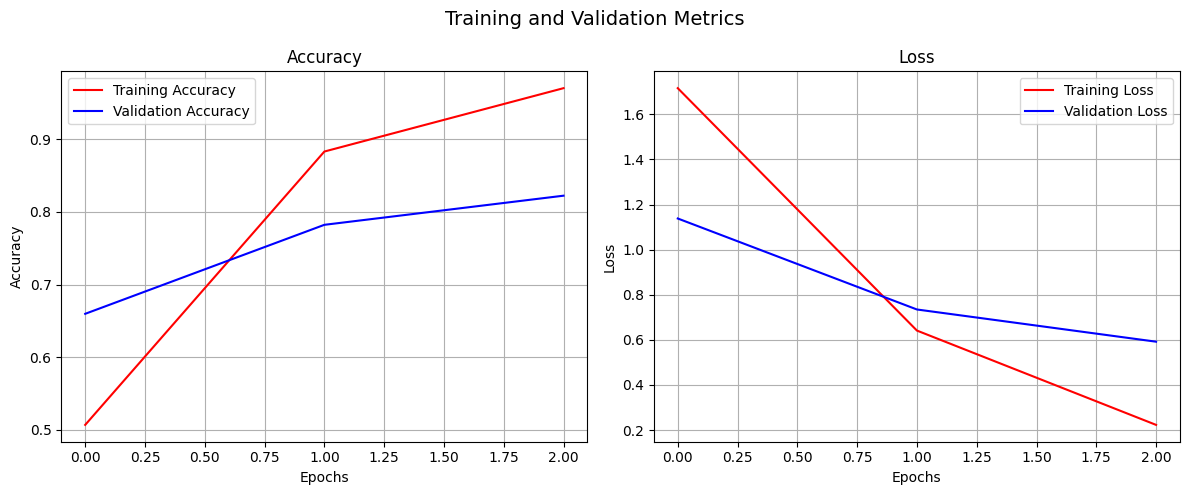

In [17]:
# Mendapatkan akurasi dan loss dari pelatihan dan validasi
acc = history_inceptionV3.history['accuracy']
val_acc = history_inceptionV3.history['val_accuracy']
loss = history_inceptionV3.history['loss']
val_loss = history_inceptionV3.history['val_loss']

# Mendapatkan jumlah epoch
epochs = range(len(acc))

# Membuat subplots untuk akurasi dan loss
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Training and Validation Metrics', fontsize=14)

# Plot akurasi
ax[0].plot(epochs, acc, 'r', label="Training Accuracy")
ax[0].plot(epochs, val_acc, 'b', label="Validation Accuracy")
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid()

# Plot loss
ax[1].plot(epochs, loss, 'r', label="Training Loss")
ax[1].plot(epochs, val_loss, 'b', label="Validation Loss")
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid()

# Menampilkan plot
plt.tight_layout()
plt.show()

In [21]:
import tensorflow as tf
import zipfile
import os

# Simpan model dalam format H5
model.save('model_inceptionV3.h5')  # Format H5

# Simpan model dalam format SavedModel
model.save('model_inceptionV3_savedmodel')  # Format SavedModel

# Simpan model dalam format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan file TFLite ke disk
with open('model_inceptionV3.tflite', 'wb') as f:
    f.write(tflite_model)

# Membuat file ZIP untuk mengarsipkan semua model yang disimpan
with zipfile.ZipFile('model_inceptionV3.zip', 'w') as zipf:
    # Menambahkan file H5
    zipf.write('model_inceptionV3.h5', arcname='model_inceptionV3.h5')
    
    # Menambahkan folder SavedModel
    for root, dirs, files in os.walk('model_inceptionV3_savedmodel'):
        for file in files:
            zipf.write(os.path.join(root, file), 
                       arcname=os.path.relpath(os.path.join(root, file), 'model_inceptionV3_savedmodel'))
    
    # Menambahkan file TFLite
    zipf.write('model_inceptionV3.tflite', arcname='model_inceptionV3.tflite')

# Semua model telah disimpan dan dimasukkan ke dalam file ZIP bernama 'model_baru.zip'
print("Model telah disimpan dalam berbagai format dan dikompresi dalam model_inceptionV3.zip")

INFO:tensorflow:Assets written to: model_inceptionV3_savedmodel\assets


INFO:tensorflow:Assets written to: model_inceptionV3_savedmodel\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpvq301xx4\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpvq301xx4\assets


Model telah disimpan dalam berbagai format dan dikompresi dalam model_inceptionV3.zip


In [1]:
from tensorflow.keras.models import load_model

# Jika menggunakan layer fungsional, beri tahu `load_model` untuk mengenali layer tersebut
model = load_model('model_inceptionV3.h5')
print("Model berhasil dimuat.")

Model berhasil dimuat.


In [35]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Fungsi untuk memuat dan memproses gambar
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(180, 180,3))  
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    img_array = img_array / 255.0 
    return img_array

# Masukkan path gambar baru
image_path = 'C:/Dataset/images11.jpg'
input_image = preprocess_image(image_path)

# Prediksi
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions)
confidence = np.max(predictions)
 
labels = ["Acne",
    "Actinic Cheilitis",
    "Actinic Keratosis",
    "Basall Cell Carcinoma",
    "Bullous Disease",
    "Cacar Air",
    "Eczema",
    "Infeksi Jamur",
    "Kutil",
    "Skin Cancer",
    "Urticaria Hives",]  
print(f"Prediksi: {labels[predicted_class]} dengan kepercayaan {confidence:.2f}")

1/1 [==============================] - 0s 99ms/step
Prediksi: Infeksi Jamur dengan kepercayaan 0.69


In [99]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Fungsi untuk memperbaiki nama lapisan
def fix_layer_names(model):
    for layer in model.layers:
        if '/' in layer.name:
            layer._name = layer.name.replace('/', '_')  # Ganti '/' dengan '_'
    return model

# Fungsi untuk membangun model DenseNet169
def build_MobileNetV2_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model = fix_layer_names(base_model)  # Memperbaiki nama lapisan
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)  # Fully connected layer
    predictions = Dense(11, activation='softmax')(x)  # Output layer

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False  # Freeze layers

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

# Membuat model DenseNet169
MobileNetV2_model = build_MobileNetV2_model()
MobileNetV2_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
# Callback untuk menghentikan pelatihan setelah akurasi mencapai target
class StopAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.97):
        super(StopAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if train_acc and train_acc >= self.target_accuracy:
            print(f"\nAkurasi pelatihan mencapai {train_acc:.2f}. Pelatihan dihentikan.")
            self.model.stop_training = True

        if val_acc and val_acc >= self.target_accuracy:
            print(f"\nAkurasi validasi mencapai {val_acc:.2f}. Pelatihan dihentikan.")
            self.model.stop_training = True

# Callback EarlyStopping untuk memantau akurasi validasi
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',     # Pantau akurasi validasi
    patience=3,                 # Tunggu hingga 3 epoch tanpa peningkatan
    restore_best_weights=True,  # Kembalikan bobot terbaik setelah berhenti
    verbose=1                   # Tampilkan log saat pelatihan dihentikan
)

# Callback ReduceLROnPlateau untuk menyesuaikan learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  # Pantau akurasi validasi
    factor=0.5,              # Kurangi learning rate 50%
    patience=3,              # Tunggu 3 epoch tanpa peningkatan
    verbose=1,               # Tampilkan informasi perubahan LR
    mode='max'               # Karena kita memaksimalkan akurasi
)

# Latih model DenseNet
history_MobileNetV2 = MobileNetV2_model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    callbacks=[
        StopAtAccuracy(target_accuracy=0.97),  # Callback custom
        early_stopping,                        # Hentikan jika stagnan
        reduce_lr                              # Sesuaikan learning rate
    ]
)

Epoch 1/50
 11/166 [>.............................] - ETA: 18:17 - loss: 1.8549 - accuracy: 0.3949